In [2]:
# ============== DATA MANIPULATION AND ANALYSIS LIBRARIES ==============
import numpy as np                    # Numerical computing library for array operations and mathematical functions
import pandas as pd                   # Data manipulation and analysis library for structured data

# ============== VISUALIZATION LIBRARIES ==============
import matplotlib.pyplot as plt       # Core plotting library for creating static, interactive, and publication-quality visualizations
import matplotlib.image as img        # Module for image handling within matplotlib
import seaborn as sns                 # Statistical data visualization library based on matplotlib
sns.set_style('darkgrid')             # Set the visual style for seaborn plots to 'darkgrid'

# ============== SYSTEM LIBRARIES ==============
import os                             # Operating system interface for file and directory operations
import pathlib                        # Object-oriented filesystem paths manipulation
import warnings                       # Warning control mechanism
warnings.filterwarnings('ignore')     # Suppress warning messages to keep output clean

# ============== DEEP LEARNING LIBRARIES ==============
import tensorflow as tf              # Core machine learning library
import keras                         # High-level neural networks API (now part of TensorFlow)
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # For real-time data augmentation during training

# Deep Learning Model Components
from keras.layers import Conv2D         # 2D Convolutional layer for image processing
from keras.layers import MaxPooling2D   # 2D Max pooling operation for spatial data
from keras.layers import Flatten        # Flattens input to create 1D feature vector
from keras.layers import Dense          # Fully connected neural network layer
from keras.layers import Activation     # Activation function layers
from keras.layers import Dropout        # Regularization technique to prevent overfitting
from keras.layers import BatchNormalization  # Batch normalization layer for training stability

# Model Architecture and Training
from keras.models import Model, Sequential  # Sequential for linear stack of layers, Model for more complex architectures
from keras.optimizers import Adam, AdamW    # Optimization algorithms for training
from keras.metrics import categorical_crossentropy  # Loss function for multi-class classification
from tensorflow.keras.regularizers import l2  # L2 regularization to prevent overfitting

# ============== IMAGE PROCESSING LIBRARIES ==============
import cv2                           # OpenCV computer vision library
import imageio                       # Library for reading and writing image data

# ============== MACHINE LEARNING UTILITIES ==============
from sklearn.metrics import confusion_matrix, classification_report  # Evaluation metrics for classification models
from sklearn.model_selection import train_test_split                # Split data into training and testing sets

In [3]:
Train_path = "/kaggle/input/brainmri/archive(2)/Training"
Test_path = "/kaggle/input/brainmri/archive(2)/Testing"

In [4]:
if tf.config.list_physical_devices('GPU'):
    print("Using GPU")
else:
    print("Using CPU")

Using GPU


In [5]:
# ============== DATA PREPARATION AND AUGMENTATION ==============

# Create a training data generator with data augmentation and validation split
# - rescale: Normalizes pixel values from [0,255] to [0,1] by multiplying with 1/255
# - validation_split: Reserves 30% of the data for validation purposes
Train_Gen = ImageDataGenerator(
    rescale = 1./255,         # Normalize pixel values to [0,1] range
    validation_split = 0.3    # Reserve 30% of images for validation
)

# Create a test data generator with only normalization (no augmentation)
Test_Gen = ImageDataGenerator(
    rescale = 1./255          # Normalize pixel values to [0,1] range
)

# Configure and load the TRAINING dataset
# This generates batches of augmented/normalized data from images in directory
Train = Train_Gen.flow_from_directory(
    "/kaggle/input/brainmri/archive(2)/Training",  # Source directory containing class sub-folders
    target_size=(224, 224),   # Resize all images to 224x224 pixels (standard input size for many CNNs)
    batch_size=8,             # Number of images to include in each batch
    class_mode='categorical',  # For multi-class classification with one-hot encoding
    shuffle=True,             # Shuffle the order of images to prevent learning sequence patterns
    subset='training'         # Specify this is the training portion (70% based on validation_split)
) 

# Configure and load the VALIDATION dataset
# Uses the same source directory but takes the validation portion
val = Train_Gen.flow_from_directory(
    "/kaggle/input/brainmri/archive(2)/Training",  # Same source directory as training
    target_size=(224, 224),   # Same image dimensions as training
    batch_size=8,             # Same batch size as training
    class_mode='categorical',  # Same encoding as training
    shuffle=False,            # No shuffling for validation to ensure consistent evaluation
    subset='validation'       # Specify this is the validation portion (30% based on validation_split)
)

# Configure and load the TEST dataset
Test = Test_Gen.flow_from_directory(
    "/kaggle/input/brainmri/archive(2)/Testing",  
    target_size=(224, 224),   # Same image dimensions
    batch_size=8,             # Same batch size
    class_mode='categorical',  # Same encoding
    shuffle=True,             # Shuffle test data
)


Found 2010 images belonging to 2 classes.
Found 860 images belonging to 2 classes.
Found 409 images belonging to 2 classes.


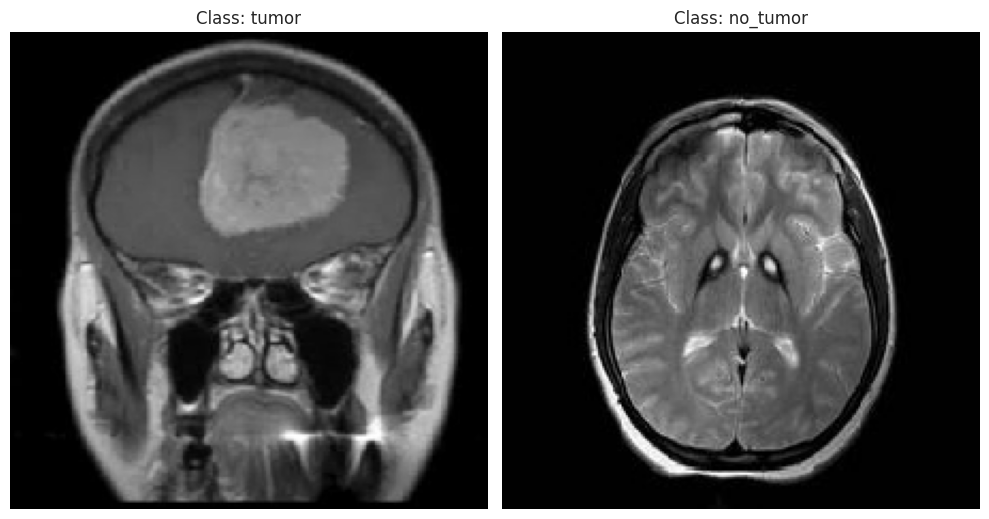

In [6]:
# ============== DATASET VISUALIZATION ==============

# Extract a single batch of training data (images and their corresponding labels)
images, labels = next(Train)  # Get batch from the Train generator defined earlier

# Convert one-hot encoded labels back to class indices
# - One-hot encoded: [0,1,0,0] → class_index: 1
class_indices = np.argmax(labels, axis=1)

# Create a mapping from numerical indices back to human-readable class names
# - Inverts the class_indices dictionary from Train generator
# - Example: {0: 'glioma', 1: 'meningioma', 2: 'no_tumor', 3: 'pituitary'}
idx_to_class = {v: k for k, v in Train.class_indices.items()}

# Create a figure for displaying sample images
plt.figure(figsize=(10, 10))  # Set the overall figure size

# Initialize tracking variables
shown_classes = set()  # Keep track of which classes we've already shown
i = 0  # Counter (unused in this code)

# Loop through the batch of images and their labels
for img, label in zip(images, class_indices):
    class_name = idx_to_class[label]  # Get the human-readable class name
    
    # Show only one example of each class (for diversity in visualization)
    if class_name not in shown_classes:
        plt.subplot(1, 2, len(shown_classes) + 1)  # Create a 1×4 grid of subplots
        plt.imshow(img)                            # Display the image
        plt.title(f"Class: {class_name}")          # Add the class name as title
        plt.axis("off")                            # Hide the x and y axes
        shown_classes.add(class_name)              # Mark this class as shown
    
    # Stop once we've shown one example from each of the 4 classes
    if len(shown_classes) == 4:
        break

# Adjust spacing between subplots for better appearance
plt.tight_layout()

# Display the final figure with all subplots
plt.show()

In [9]:
class Model:
    """
    A Convolutional Neural Network (CNN) model class for brain tumor classification.
    
    This class implements a relatively simple CNN architecture with:
    - 2 convolutional blocks (Conv2D -> Pooling -> BatchNorm)
    - Dropout layers for regularization
    - L2 regularization on convolutional and dense layers
    - A fully connected output layer with softmax activation
    
    Attributes:
        input_shape (tuple): The shape of the input images (height, width, channels).
                            Default is (224, 224) which implies (224, 224, 3) with channels.
        num_classes (int): Number of output classes for classification.
                          Default is 4 (likely glioma, meningioma, no_tumor, pituitary).
    """
    def __init__(self, input_shape=(224, 224), num_classes=2):
        """
        Initialize the Model with specified input shape and number of classes.
        
        Args:
            input_shape (tuple): The shape of the input images (height, width).
                               Channels dimension (3) will be added automatically.
            num_classes (int): Number of classes to classify into.
        """
        self.input_shape = input_shape
        self.num_classes = num_classes
    
    def model(self):
        """
        Builds and returns a Sequential CNN model.
        
        Architecture:
            - First Conv Block: 32 filters (3x3) -> AveragePooling -> BatchNorm
            - Second Conv Block: 64 filters (3x3) with L2 reg -> MaxPooling -> BatchNorm -> Dropout(0.2)
            - Flatten layer to convert 2D feature maps to 1D feature vector
            - Dense layer with 64 neurons, ReLU activation and L2 regularization
            - Dropout(0.3) for regularization
            - Output layer with softmax activation for multi-class classification
            
        Returns:
            keras.models.Sequential: A compiled Keras Sequential model ready for training
        """
        model = Sequential([
            # First Convolutional Block
            tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', 
                                  input_shape=self.input_shape),  # 32 filters, 3x3 kernel
            tf.keras.layers.AveragePooling2D(pool_size=(2,2)),    # Reduces spatial dimensions by half
            tf.keras.layers.BatchNormalization(),                 # Normalizes activations for training stability
            
            # Second Convolutional Block
            tf.keras.layers.Conv2D(64, (3,3), activation='relu6', padding='same', 
                                  kernel_regularizer=l2(0.001)),  # 64 filters with L2 regularization
            tf.keras.layers.MaxPooling2D(pool_size=(2,2)),        # Further reduces spatial dimensions
            tf.keras.layers.BatchNormalization(),                 # Normalizes activations
            tf.keras.layers.Dropout(0.2),                         # Randomly drops 20% of connections during training
            
            # Flatten layer to transition from convolutional to dense layers
            tf.keras.layers.Flatten(),                            # Converts 2D feature maps to 1D vector
            
            # Dense layers for classification
            tf.keras.layers.Dense(64, activation='relu', 
                                 kernel_regularizer=l2(0.001)),   # 64 neurons with L2 regularization
            tf.keras.layers.Dropout(0.3),                         # Drops 30% of connections to prevent overfitting
            tf.keras.layers.Dense(self.num_classes, 
                                 activation='sigmoid')            # Output layer with softmax for classification
        ])
        
        return model

In [13]:
cnn = Model(input_shape=(224, 224, 3), num_classes=2)
model = cnn.model()

In [14]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling2d_1                  │ (None, 112, 112, 32)        │               0 │
│ (AveragePooling2D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 112, 112, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 56, 56, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │      12,845,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,865,026 (49.08 MB)

 Trainable params: 12,864,834 (49.08 MB)

 Non-trainable params: 192 (768.00 B)

In [15]:
history = model.fit(
    Train,
    epochs=25,
    validation_data=val,
)


Epoch 1/25


I0000 00:00:1744277394.395159     121 service.cc:148] XLA service 0x7e3fec042d00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744277394.396010     121 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1744277394.743396     121 cuda_dnn.cc:529] Loaded cuDNN version 90300


  4/252 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - accuracy: 0.4818 - loss: 3.0896

I0000 00:00:1744277399.531393     121 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


252/252 ━━━━━━━━━━━━━━━━━━━━ 27s 73ms/step - accuracy: 0.8440 - loss: 1.3415 - val_accuracy: 0.8628 - val_loss: 0.5801
Epoch 2/25
252/252 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9179 - loss: 0.3658 - val_accuracy: 0.9163 - val_loss: 0.4099
Epoch 3/25
252/252 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9332 - loss: 0.2560 - val_accuracy: 0.9558 - val_loss: 0.4080
Epoch 4/25
252/252 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.9214 - loss: 0.2967 - val_accuracy: 0.9349 - val_loss: 0.7619
Epoch 5/25
252/252 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.9268 - loss: 0.2495 - val_accuracy: 0.9686 - val_loss: 0.4456
Epoch 6/25
252/252 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.9281 - loss: 0.2122 - val_accuracy: 0.9767 - val_loss: 0.4211
Epoch 7/25
252/252 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.9590 - loss: 0.2139 - val_accuracy: 0.9744 - val_loss: 0.4321
Epoch 8/25
252/252 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.9451 - loss: 0.1997 - val_accuracy: 0.96

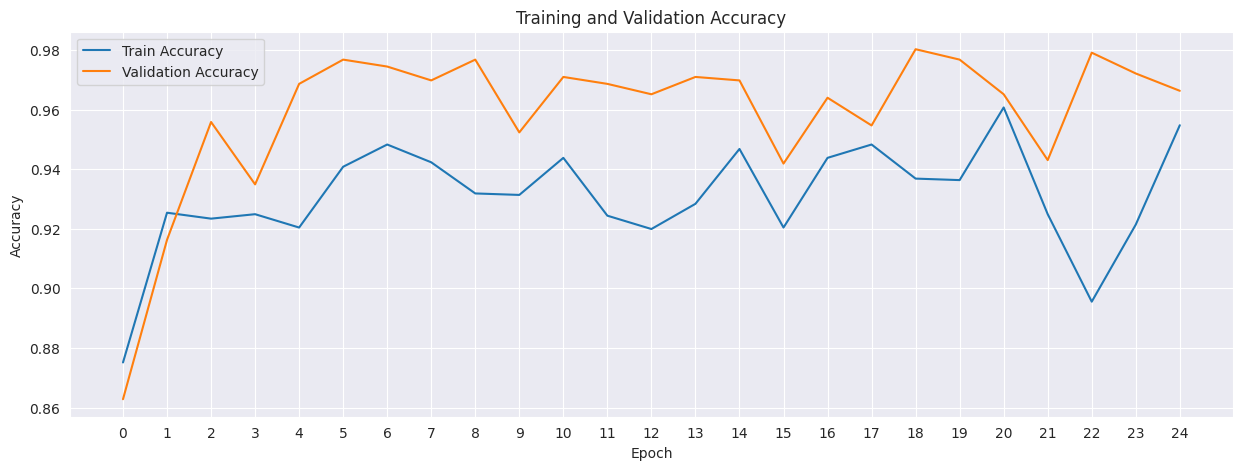

In [27]:
plt.figure(figsize=(15,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.xticks(range(0,25,1))
plt.ylabel('Accuracy')
plt.legend()
plt.grid(visible = True)
plt.show()

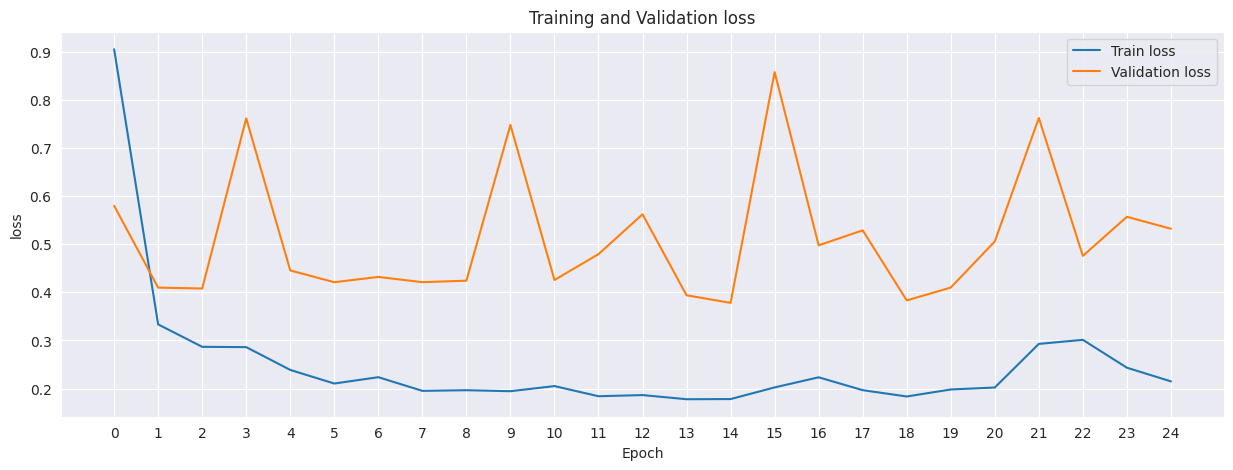

In [28]:
plt.figure(figsize=(15,5))
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epoch')
plt.xticks(range(0,25,1))
plt.ylabel('loss')
plt.legend()
plt.grid(visible = True)
plt.show()

In [29]:
# ============== MODEL EVALUATION ==============

# Evaluate the trained model on test data
# - This computes both loss and accuracy metrics on the test dataset
# - The model.evaluate() method runs inference on all batches of the test dataset
test_loss, test_acc = model.evaluate(Test)

# Display the test accuracy formatted to 2 decimal places
print(f"Test accuracy: {test_acc:.2f}")

# Generate predictions on test data for detailed performance analysis
# -------------------------------------------------------------
# Calculate the number of batches in the test dataset
train_steps = len(Test)

# Get model predictions on the test dataset
# - model.predict() returns probability distributions across all classes
# - np.argmax(..., axis=1) converts these probabilities to class indices
# - 'steps=train_steps' ensures we process the entire test dataset
y_pred_test = np.argmax(model.predict(Test, steps=train_steps), axis=1)  # Predicted labels

# Get the true labels from the test data generator
# - Test.classes provides the ground truth class indices
y_true_test = Test.classes  # True labels from the generator


52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.7738 - loss: 1.2569
Test accuracy: 0.78
52/52 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step


In [30]:
class_names = list(Test.class_indices.keys())
print("Class Names:", class_names)

Class Names: ['no_tumor', 'tumor']


In [31]:
def plot_confusion_matrix(y_true, y_pred, class_names, title="Confusion Matrix"):
    """
    Plots a confusion matrix as a heatmap using seaborn and matplotlib.
    
    A confusion matrix shows the performance of a classification model by comparing
    predicted labels with true labels, helping to identify where the model confuses 
    different classes.
    
    Parameters:
    -----------
    y_true : array-like
        Ground truth (correct) target values.
    
    y_pred : array-like
        Estimated targets as returned by a classifier.
    
    class_names : list or array-like
        List of class names corresponding to the indices in y_true and y_pred.
        Used for axis labels.
    
    title : str, default="Confusion Matrix"
        Title for the plot.
    
    Notes:
    ------
    - The rows represent the true labels
    - The columns represent the predicted labels
    - The diagonal elements represent correct predictions
    - Off-diagonal elements represent misclassifications
    - Higher numbers on the diagonal indicate better performance
    
    Returns:
    --------
    None. Displays the confusion matrix visualization.
    """
    # Calculate the confusion matrix from true and predicted labels
    cm = confusion_matrix(y_true, y_pred)
    
    # Create a figure with specified size (15x5 inches)
    plt.figure(figsize=(15, 5))
    
    # Create the heatmap visualization
    sns.heatmap(
        cm,                    # Confusion matrix data
        annot=True,            # Show values in cells
        fmt='d',               # Display values as integers
        cmap='Blues',          # Blue color map (darker blue = higher values)
        xticklabels=class_names,  # Label x-axis with class names
        yticklabels=class_names   # Label y-axis with class names
    )
    
    # Add title and axis labels for clarity
    plt.title(title)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    
    # Display the plot
    plt.show()

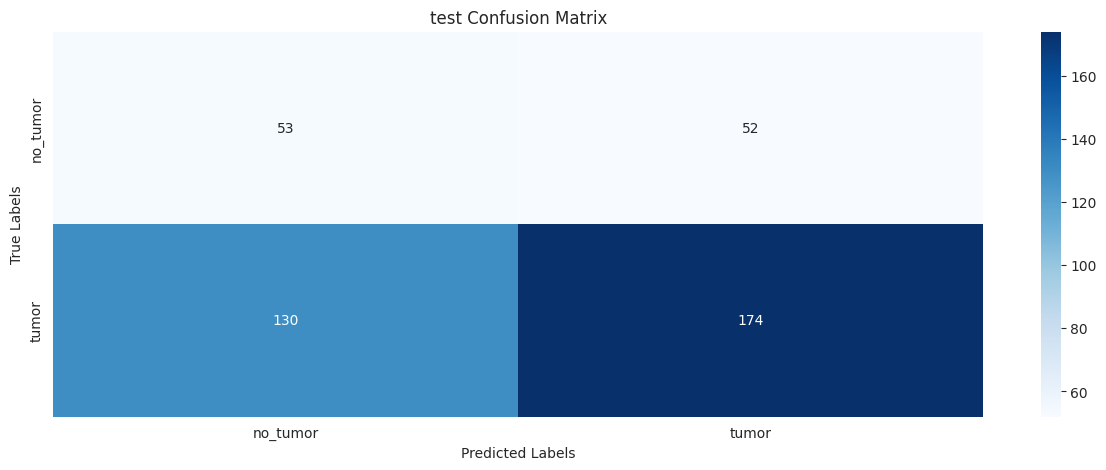

In [32]:
plot_confusion_matrix(y_true_test, y_pred_test, class_names, title="test Confusion Matrix")

In [37]:
MobileNetV2 = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
MobileNetV2.trainable = False  # Freeze pretrained layers

MobileNetV2 = Sequential([
    MobileNetV2,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='sigmoid')
])


In [38]:
MobileNetV2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [39]:
history2 = MobileNetV2.fit(
    Train,
    epochs=25,
    validation_data=val,
)

Epoch 1/25
252/252 ━━━━━━━━━━━━━━━━━━━━ 28s 71ms/step - accuracy: 0.8414 - loss: 0.3846 - val_accuracy: 0.9407 - val_loss: 0.1411
Epoch 2/25
252/252 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9466 - loss: 0.1486 - val_accuracy: 0.9558 - val_loss: 0.1199
Epoch 3/25
252/252 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.9525 - loss: 0.1304 - val_accuracy: 0.9535 - val_loss: 0.1129
Epoch 4/25
252/252 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - accuracy: 0.9609 - loss: 0.1264 - val_accuracy: 0.9640 - val_loss: 0.0984
Epoch 5/25
252/252 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.9640 - loss: 0.0962 - val_accuracy: 0.9663 - val_loss: 0.0894
Epoch 6/25
252/252 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9730 - loss: 0.0820 - val_accuracy: 0.9640 - val_loss: 0.0917
Epoch 7/25
252/252 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.9704 - loss: 0.0767 - val_accuracy: 0.9640 - val_loss: 0.0919
Epoch 8/25
252/252 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.9847 - loss: 0.0508 - val_acc

In [40]:
# ============== MODEL EVALUATION ==============

# Evaluate the trained model on test data
# - This computes both loss and accuracy metrics on the test dataset
# - The model.evaluate() method runs inference on all batches of the test dataset
test_loss1, test_acc1 = MobileNetV2.evaluate(Test)

# Display the test accuracy formatted to 2 decimal places
print(f"Test accuracy: {test_acc1:.2f}")

# Generate predictions on test data for detailed performance analysis
# -------------------------------------------------------------

# Get model predictions on the test dataset
# - model.predict() returns probability distributions across all classes
# - np.argmax(..., axis=1) converts these probabilities to class indices
# - 'steps=train_steps' ensures we process the entire test dataset
y_pred_test1 = np.argmax(MobileNetV2.predict(Test, steps=train_steps), axis=1)  # Predicted labels

# Get the true labels from the test data generator
# - Test.classes provides the ground truth class indices
y_true_test1 = Test.classes  # True labels from the generator

52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.9587 - loss: 0.1016
Test accuracy: 0.95
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 90ms/step


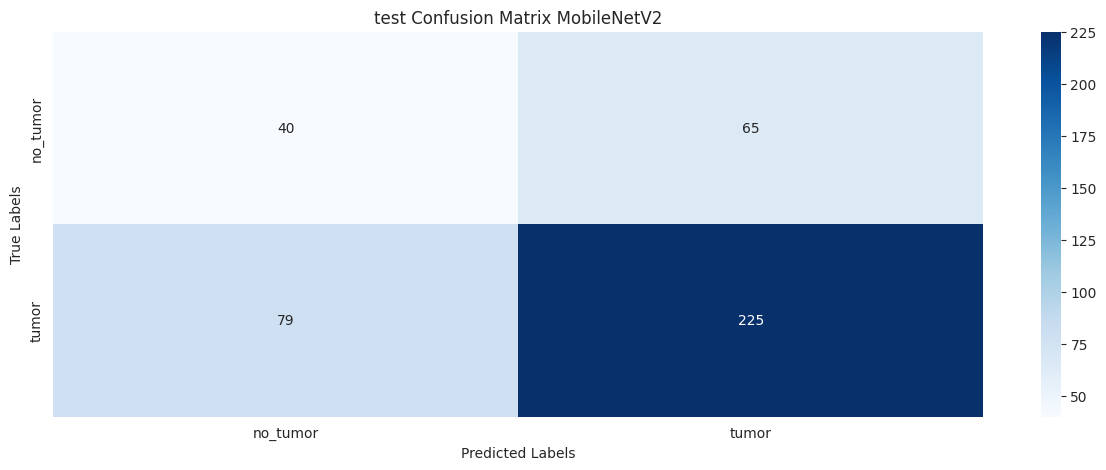

In [42]:
plot_confusion_matrix(y_true_test1, y_pred_test1, class_names, title="test Confusion Matrix MobileNetV2")